# Google Trends Data

This program obtains Google Trends Data using an unofficial API called [pytrends](https://github.com/GeneralMills/pytrends). Thank you to the creators!

In [1]:
# import all necessary packages
import pandas as pd
import numpy as np
import lxml
import requests
import requests_cache
import pytrends
from pytrends.request import TrendReq
from bs4 import BeautifulSoup
from collections import Counter
from matplotlib import pyplot as plt
plt.style.use('ggplot')
requests_cache.install_cache("cache")

# required info
google_username = "***@gmail.com"
google_password = "***"

In [2]:
# Login to Google. Only need to run this once, the rest of requests will use the same session.
pytrend = TrendReq(google_username, google_password, custom_useragent=None)

I first tried to look at all the search terms once in one payload, but that gave me different results than if I searched the terms separately. The reason is because when I used all the terms at once, the trends data returned was actually comparing each of the search terms and their popularity to each other. This is not what we wanted, so I decided to do them all separately.

**A side note:** According to the [Google Trends Search Tips](https://support.google.com/trends/answer/4359582?hl=en) page, searching a term like *tennis shoes* results in "searches containing both tennis and shoes in any order. Results can also include searches like red tennis shoes, funny shoes for tennis, or tennis without shoes." Therefore, I chose to use terms like *walmart stock price* so that each word would be considered as well as many combinations of these words.

We decided to start by taking a look at five companies from different sectors to analyze their search terms: Walmart, Goldman Sachs, Exxon Mobile, Facebook, and Nike.

In [3]:
# list of test search terms
search_list = ['walmart stock price', 'goldman sachs stock price', 'exxon mobile stock price', 'facebook stock price', 'nike stock price']

# get the comparison search data
pytrend.build_payload(kw_list = search_list, geo = 'US', timeframe = 'today 3-m')
compare_df = pytrend.interest_over_time()
compare_df.head()

,walmart stock price,goldman sachs stock price,exxon mobile stock price,facebook stock price,nike stock price
date,,,,,
2016-12-15,13,2,0,33,5
2016-12-16,16,2,0,34,7
2016-12-17,12,0,0,11,3
2016-12-18,2,0,2,18,4
2016-12-19,11,2,0,31,5


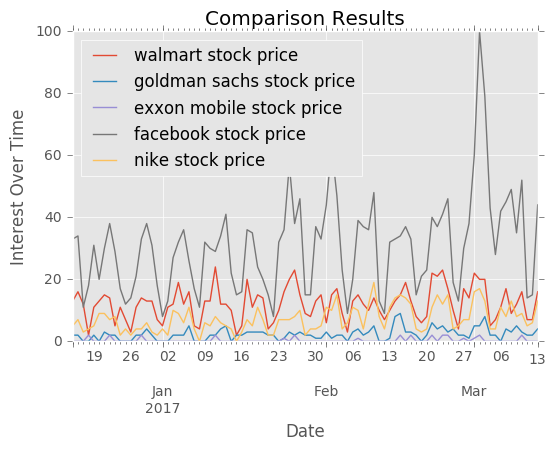

In [5]:
compare_df.plot()
plt.title('Comparison Results')
plt.xlabel('Date')
plt.ylabel('Interest Over Time')
plt.show()

Notice that from the plot above, we can clearly see that Facebook was searched much more often than Exxon Mobile for example.

Because of the way the API is structured, I had to make five separate pyloads and get the individual data frames that way before combining them into a single data frame. Notice that the numbers are different from the data frame above!

Before that, we quickly needed to change the search term list into a list of lists with each term in its own list. This is because the API requires the keywords to be in a list format.

In [6]:
# function to quickly change the search term list into a list of lists
def listit(t):
    term_listed = []
    term_listed.append(t)
    return term_listed

In [7]:
search_list2 = [listit(t) for t in search_list]
search_list2

[['walmart stock price'],
 ['goldman sachs stock price'],
 ['exxon mobile stock price'],
 ['facebook stock price'],
 ['nike stock price']]

We created a function to pull each company's information separately and then put them together.

In [23]:
# function to get each company's data frame separately
def get_term_df(term):
    pytrend.build_payload(kw_list = term, geo = 'US', timeframe = 'today 3-m')
    new_df = pytrend.interest_over_time()
    return new_df

In [24]:
# combine all data frames by column since the indexes are the same anyways
combined_df = pd.concat([get_term_df(search_term) for search_term in search_list2], axis = 1)
combined_df.head()

,walmart stock price,goldman sachs stock price,exxon mobile stock price,facebook stock price,nike stock price
date,,,,,
2016-12-15,49,37,64,32,48
2016-12-16,48,26,0,40,54
2016-12-17,49,66,0,17,22
2016-12-18,8,0,85,17,19
2016-12-19,32,26,0,35,37


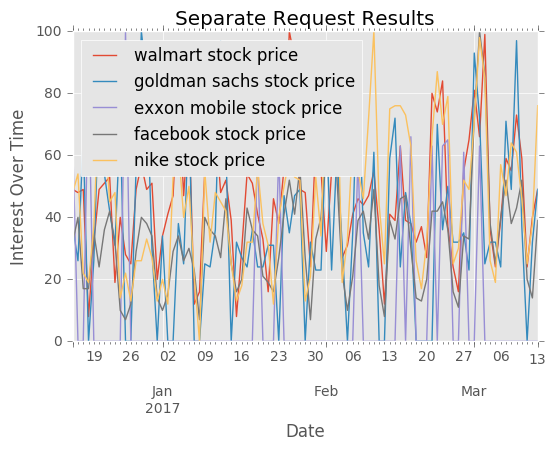

In [25]:
combined_df.plot()
plt.title('Separate Request Results')
plt.xlabel('Date')
plt.ylabel('Interest Over Time')
plt.show()

The plot above is too messy and it is difficult to deduce anything of value from it. Therefore, we decided to go ahead with just one company and analyze its data. This way, we can replicate the process with other companies. 

At this point, we decided to add a few more elements to our request function. The first was to obtain data from the past three years instead of just the past three months. Our reasoning behind this decision was to make sure that any large gains or losses were actually significant within the larger scope. This ensures that our predictions are more accurate.

Another element we decided to encorporate was the categories feature on Google Trends. For example, if you search the term 'jaguar', you can add a category to indicate if you mean the animal or the car manufacturer. We decided to use the three most relevant categories to us, Financial, Business & Industrial, and News. Even if we are looking at a technology company like Apple for example, we still would want to use the same categories to obtain more precise results. 

Our example company is **Coca-Cola**. We considered all possible variations of the company's name as well as their ticker symbol. Since we are using the Financial category as well, our resutls will include search terms like "losses" & "price".

In [ ]:
# function to get each company's data frame separately
# now includes past 3 years and categories
def get_term_df2(term, cat_num):
    pytrend.build_payload(kw_list = term, cat = cat_num, geo = 'US', timeframe = '2014-01-05 2017-03-11')
    new_df = pytrend.interest_over_time()
    return new_df

In [12]:
KO_search_terms = ['coca-cola', '"coca cola"', 'KO', 'coke']
cat_list = [7,12,16]
cat_names = ['Financial', 'Business & Industrial', 'News']

KO_list = [listit(t) for t in KO_search_terms]
KO_list

[['coca-cola'], ['"coca cola"'], ['KO'], ['coke']]

In [13]:
all_df = pd.concat([get_term_df2(x, i) for x in KO_list for i in cat_list], axis = 1)

In [14]:
# section off past six months for testing
reduced_df = all_df.loc["2016-09-13":"2017-03-13"]
reduced_df.head()

,coca-cola,coca-cola,coca-cola,"""coca cola""","""coca cola""","""coca cola""",KO,KO,KO,coke,coke,coke
date,,,,,,,,,,,,
2016-09-18,88,36,34,71,12,39,45,64,16,36,26,14
2016-09-25,32,27,24,84,11,36,64,65,15,34,32,74
2016-10-02,25,33,27,75,11,40,56,60,14,23,27,15
2016-10-09,51,33,31,66,11,41,53,68,18,34,27,42
2016-10-16,93,35,30,67,12,38,69,71,13,27,30,19


We then took the average by the search term.

In [16]:
by_term_avg = reduced_df.groupby(np.arange(len(reduced_df.columns))//3, axis=1).mean()
by_term_avg = np.round(by_term_avg, decimals=2)
by_term_avg.columns = KO_search_terms
by_term_avg.head()

,coca-cola,"""coca cola""",KO,coke
date,,,,
2016-09-18,52.67,40.67,41.67,25.33
2016-09-25,27.67,43.67,48.00,46.67
2016-10-02,28.33,42.00,43.33,21.67
2016-10-09,38.33,39.33,46.33,34.33
2016-10-16,52.67,39.00,51.00,25.33


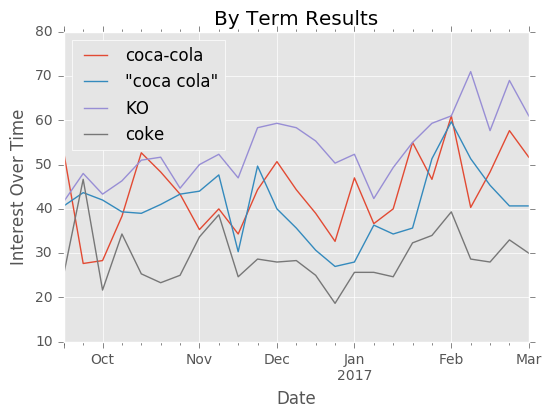

In [17]:
by_term_avg.plot()
plt.title('By Term Results')
plt.xlabel('Date')
plt.ylabel('Interest Over Time')
plt.show()

We then decided that it would actually be more useful to aggregate by category and see if a certain category behaved differently than the others.

In [29]:
by_cat_avg = reduced_df.groupby(np.arange(len(reduced_df.columns))//4, axis=1).mean()
by_cat_avg.columns = cat_names
by_cat_avg.head()

,Financial,Business & Industrial,News
date,,,
2016-09-18,57.25,40.00,23.00
2016-09-25,41.75,44.00,38.75
2016-10-02,40.00,41.75,19.75
2016-10-09,45.25,43.25,30.25
2016-10-16,56.25,47.50,22.25


Just to get a visual sense of the different categories and their results, here is a plot of the data.

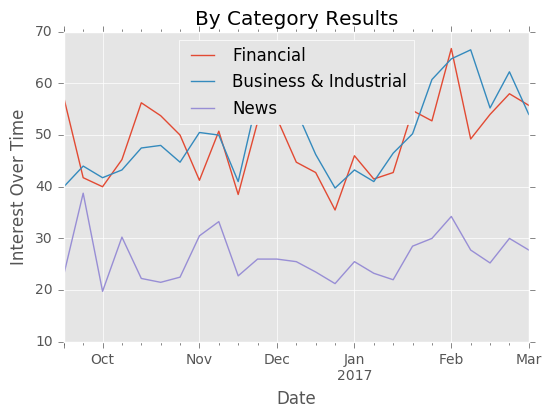

In [28]:
by_cat_avg.plot()
plt.title('By Category Results')
plt.xlabel('Date')
plt.ylabel('Interest Over Time')
plt.show()

Looking at the plot above, we can see that for the most part, the three categories move in the same direction. The news category shows generally lower results, but that is to be expected since news coverage per company tends to be low. This is reassuring to us when we average the three categories into one column. 

Below, we took the large dataframe that includes the past three years of information, averaged it all together, and then put in into a list for convenience.

In [31]:
result = all_df.mean(axis=1)
result = result.tolist()
result

[38.25,
 32.333333333333336,
 40.5,
 37.916666666666664,
 79.416666666666671,
 41.833333333333336,
 48.083333333333336,
 44.25,
 42.916666666666664,
 39.583333333333336,
 35.583333333333336,
 37.333333333333336,
 41.416666666666664,
 40.0,
 39.0,
 37.583333333333336,
 41.0,
 45.083333333333336,
 34.333333333333336,
 36.25,
 34.0,
 30.666666666666668,
 31.333333333333332,
 35.416666666666664,
 33.666666666666664,
 40.75,
 35.083333333333336,
 37.833333333333336,
 45.166666666666664,
 42.5,
 40.833333333333336,
 42.0,
 36.5,
 33.5,
 33.0,
 35.5,
 40.166666666666664,
 37.333333333333336,
 41.583333333333336,
 40.333333333333336,
 37.166666666666664,
 53.583333333333336,
 43.666666666666664,
 38.583333333333336,
 37.583333333333336,
 40.666666666666664,
 30.333333333333332,
 38.333333333333336,
 30.25,
 33.416666666666664,
 30.416666666666668,
 30.416666666666668,
 37.75,
 35.416666666666664,
 34.0,
 39.166666666666664,
 42.25,
 43.25,
 42.333333333333336,
 40.25,
 41.333333333333336,
 40.